#### Last Modified: July 26st, 2022 (Opal). 

## sOpInf on Three-Dimensional Steady MAS Solar Wind Radial Speed

In [1]:
import os
curr_dir = os.getcwd()
os.chdir("../")
print("current directory path = ", os.getcwd())

current directory path =  /Users/oissan/PycharmProjects/Space-Weather-ROM-Revised


In [2]:
import numpy as np
import scipy
import scipy.linalg as la
from scipy import signal
from scipy import  stats
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.model.variable import Variable
import rom_operator_inference as roi
from MHD.notebook_functions import regularizer
from scipy.interpolate import RegularGridInterpolator
import time
import astropy.units as u
import cv2

In [3]:
import matplotlib.pyplot as plt
import matplotlib
# use LaTeX fonts in the plot
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

## Import MHD solar wind radial velocity results.

In [4]:
# mas output - br, rho, vr
cr = "2210"
mas_path = get_mas_path(cr=cr)
model = MASOutput(mas_path)
print(model.variables)
# get back to original directory
os.chdir(curr_dir)

['bp', 'br', 'bt', 'p', 'rho', 't', 'vp', 'vr', 'vt']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [7]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p = np.append(p, 2*np.pi) 

# append the first slice p=0 to velocity matrix. 
f = np.append(f,[f[0,:, :]],axis=0)

# save radial velocity 
V = np.array(f)

In [8]:
PlotSlices = False
if PlotSlices == True:
    for ii in np.arange(len(r)):
        fig, ax = plt.subplots(figsize=(11, 5))
        im = ax.imshow(f[:, :, ii].T,
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                    vmin = 300, vmax = 700, cmap="viridis", aspect="auto", origin="lower")

        ax.set_title("$V_{r}$, r = " + str(round(r[ii].to(u.AU).value, 2)) + " AU")
        ax.set_yticks([-90, -45, 0, 45, 90])
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xlabel("Carrington Longitude (Deg.)")
        ax.set_ylabel("Latitude (Deg.)")
        cbar = fig.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('km/s', rotation=90)
        file_name = "figs/Animation/fig_" + str(ii) + ".png"
        fig.savefig(file_name, dpi=500)

In [9]:
SaveVid = False

if SaveVid:
    # choose codec according to format needed
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter("sw_vid.mov", fourcc, 30, (5500, 2500))
    # loop over save images. 
    for j in range(len(r)):
        file_name = "figs/Animation/fig_" + str(j) + ".png"
        img = cv2.imread(file_name)
        video.write(img)
    cv2.destroyAllWindows()
    video.release()

### Background: Solar Wind

Due to the high temperature of the Sun's upper atmosphere, called the corona, particles are able to escape the Sun's gravity, resulting in the Solar Wind. The solar wind is a stream of charged particles mostly consists of electrons, protons and alpha particles. The solar wind varies in density, temperature and speed over time and over solar latitude and longitude.

Here we will model the radial velocity of the Solar Wind protons denoted by $v_{r}$. As the solar wind propagates out in the heliosphere it can reach velocities of around 300-700 km/sec. 

In [10]:
def plot_slices_fig(data, title="MHD CR2210", figsave="figs/mhd_2D_slices.png", vmin=300, vmax=700, cbar_label="km/s"):
    fig = plt.figure(figsize=(10,12))
    for id_subplot, snapshot in enumerate(np.append(np.arange(0, len(r), 30), len(r)-1), start=1):
        plt.subplot(4, 2, id_subplot)
        im = plt.imshow(data[:, :, snapshot].T,  vmin=vmin, vmax=vmax, 
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[-1]*180/np.pi, t[0]*180/np.pi],   
                     cmap="plasma", aspect="auto")
        plt.title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
        plt.yticks([90, 45, 0, -45, -90])
        plt.xticks([360, 270, 180, 90, 0])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.99, 0.3, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)

    _ = cbar_ax.set_ylabel('km/s', rotation=90)


    fig.suptitle(title)
    plt.tight_layout()

    fig.savefig(figsave, dpi=300, bbox_inches='tight')

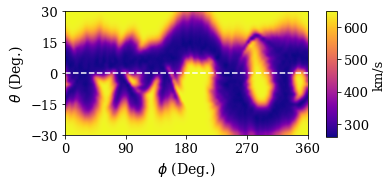

In [11]:
    fig = plt.figure(figsize=(5,5))
    for id_subplot, snapshot in enumerate(np.arange(1), start=1):
        plt.subplot(2, 1, id_subplot)
        im = plt.imshow(V[:, 36:74, 0].T,  
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, -30, 30],   
                     cmap="plasma", aspect="auto", origin="lower", interpolation="spline16")
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
        plt.yticks([30, 15,  0, -15, -30])
        plt.xticks([360, 270, 180, 90, 0])
        plt.plot(p*180/np.pi, np.zeros(len(p)), c="white", ls="--")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.53, 0.03, 0.35])
    fig.colorbar(im, cax=cbar_ax)

    _ = cbar_ax.set_ylabel('km/s', rotation=90)

plt.savefig("figs/cr2210_30rs_slice.png", dpi=500, bbox_inches='tight')

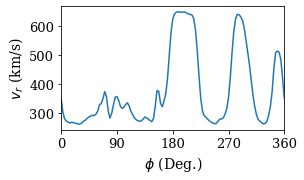

In [12]:
    fig = plt.figure(figsize=(4,5))
    for id_subplot, snapshot in enumerate(np.arange(1), start=1):
        plt.subplot(2, 1, id_subplot)
        plt.plot(p*180/np.pi, V[:, 55, 0].T)
        plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
        plt.ylabel(r"$v_{r}$ (km/s)", fontsize=14)
        plt.xticks([360, 270, 180, 90, 0])
        plt.xlim(0, 360)
        plt.yticks([300, 400, 500, 600])

plt.savefig("figs/cr2210_30rs_equator.png", dpi=500, bbox_inches='tight')

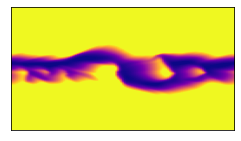

In [13]:
    fig = plt.figure(figsize=(4,5))
    for id_subplot, snapshot in enumerate(np.arange(1), start=1):
        plt.subplot(2, 1, id_subplot)
        im = plt.imshow(V[:, :, 130].T,  vmin=300, vmax=700, 
                        extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                     cmap="plasma", aspect="auto", origin="lower")

        plt.yticks([])
        plt.xticks([])


plt.savefig("snapshot3", dpi=300, bbox_inches='tight')

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62837/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


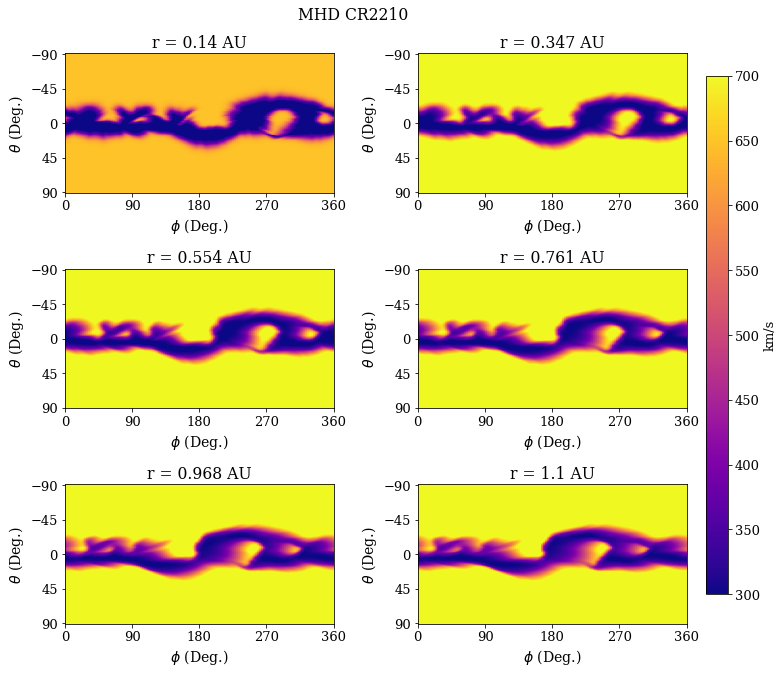

In [14]:
plot_slices_fig(data=f, title="MHD CR2210", figsave="figs/CR" + str(cr) +"/mhd_2d_slices.png")

In [15]:
def periodic_corr_2d(x, y):
    """Periodic correlation, implemented using np.correlate.

    x and y must be real sequences with the same length.
    """
    return scipy.signal.correlate2d(x, np.concatenate((y[1:, :], y)), mode='valid')

In [16]:
v1 = V[:, :, 0]

shift_vec = [0]

for ii in range(1, len(r)):
    v2 = V[:, :, ii]
    corr = periodic_corr_2d(v1, v2)
    shift_vec.append(p[np.argmax(corr)]*180/np.pi)

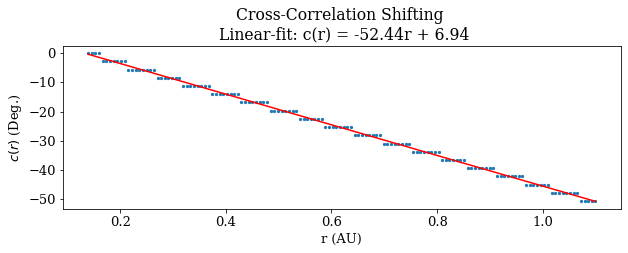

In [17]:
fig, ax = plt.subplots(figsize =(10, 3))
ax.scatter(r.to(u.AU), -np.array(shift_vec), s=5)
m, b = np.polyfit(r[:int(0.7*len(r))].to(u.AU).value, -np.array(shift_vec[:int(0.7*len(r))]), 1)
_ = ax.plot(r.to(u.AU), m*r.to(u.AU).value + b, c="r", label="linear-fit")

_ = ax.set_xlabel("r (AU)")
_ = ax.set_ylabel("$c(r)$ (Deg.)")
_ = ax.set_title("Cross-Correlation Shifting \n Linear-fit: c(r) = " + str(round(m, 2)) + "r + " + str(round(b, 2)))

In [18]:
def shift_function(r, m, b):
    return m * r + b

In [19]:
def interp_fun(p_shifted, p, t, v):
    # interpolator. 
    my_interpolating_function = RegularGridInterpolator((p, t), v)
    # create new mesh grid. 
    points = np.meshgrid(p_shifted, t)
    # flatten the mesh grid points to align with input for RegularGridInterp function.
    flat = np.array([m.flatten() for m in points])
    # pass to the interp function.
    out_array = my_interpolating_function(flat.T)
    # reshape back to original grid. 
    return out_array.reshape(*points[0].shape)

In [20]:
# initialize the data matrix. 
V_new = np.zeros((len(p), len(t), len(r)))

# initial conditon. 
V_new[:, :, 0] = V[:, :, 0]

for jj in range(1, len(r)):
    # compute shift from the linear fit above. 
    shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
    # define the new shifted coordinate.
    x_new = (p*180/np.pi + shift) % (360)
    # interpolate over the shifted coordinate
    V_new[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=V[:, :, jj]).T

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62837/1454845702.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


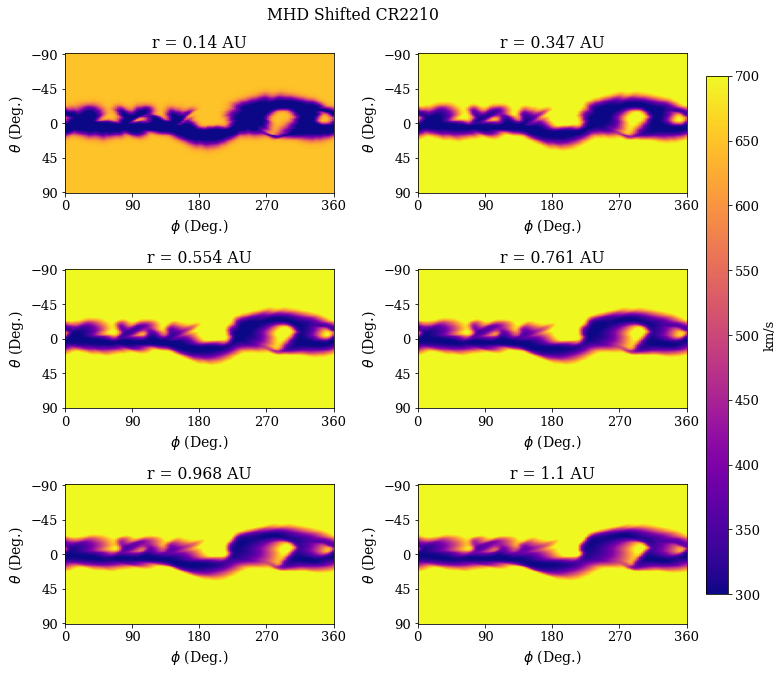

In [21]:
plot_slices_fig(data=V_new, title="MHD Shifted CR2210", figsave="figs/CR" + str(cr) + "/mhd_2D_shifted_slices.png")

## Split Training and Testing datasets. 

* Training = First $l$ radial indexes.
* Testing/Validation = Remaining $n_{r}-l$ radial indexes.

In [22]:
# set up the first l indexes used for training. 
l = int(0.7*(len(r)))

In [23]:
X = V_new

In [24]:
V_new.shape

(129, 111, 140)

In [25]:
X_train = V_new[:, :, :l]
X_test = V_new[:, :, l:]

In [26]:
r_train = r[:l]
r_test = r[l:]

In [27]:
print("X train shape", np.shape(X_train))
print("Radial distance train: " + str(r[0].to(u.AU)) + " to " + str(r[l].to(u.AU)))
print("\nX test shape", np.shape(X_test))
print("Radial distance test: " + str(r[l].to(u.AU)) + " to " + str(r[-1].to(u.AU)))

X train shape (129, 111, 98)
Radial distance train: 0.13951401782886472 AU to 0.816444039517221 AU

X test shape (129, 111, 42)
Radial distance test: 0.816444039517221 AU to 1.0996495197497314 AU


## Using the ROM Operator Inference Package

### Step 1: Choosing the Reduced-model Dimension
A simple choice for $r$ is to look at the singular values $\{\sigma_j\}_{j=1}^{n}$ of the snapshot matrix $X$ and select the number of $\sigma_{j}$ that are greater than a given threshold.
This also gives us a sense of whether or not we expect model reduction to be successful: if the singular values do not decay quickly, then we will need many modes to capture the behavior of the system.

In [28]:
def flatten(X):
    return X.reshape((len(p)*len(t), -1))
    

def undo_flatten(X):
    return X.reshape(len(p), len(t), -1)

In [29]:
svdvals = la.svdvals(flatten(X_train))
svdvals_prev = la.svdvals(flatten(V[:, :, :l]))

In [30]:
# Calculate the cumulative energy.
thresh = .998
cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
cum_energy_prev = np.cumsum(svdvals_prev) / np.sum(svdvals_prev)

# Determine the points at which the cumulative energy passes the threshold.
rank = sum([rank < thresh for rank in cum_energy])
rank_prev = sum([rank < thresh for rank in cum_energy_prev])
print(f"r (Shifted coordinates)= {rank}")
print(f"r (Eularian coordinates)= {rank_prev}")

r (Shifted coordinates)= 9
r (Eularian coordinates)= 17


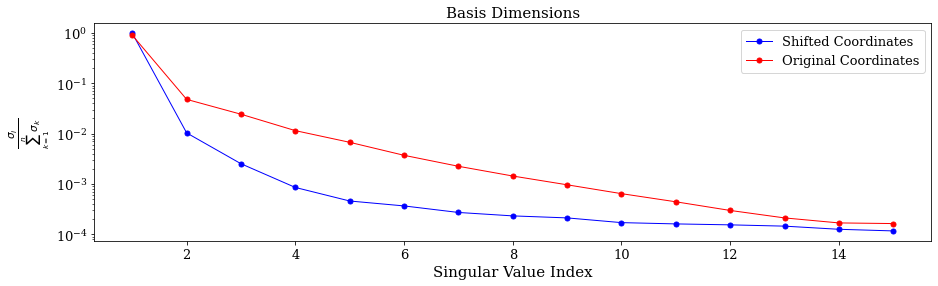

In [31]:
#Visualize cumulative energy and threshold value(s).
fig, ax = plt.subplots(figsize=(15, 4))
#plot singluar values cumulative energy
ax.plot(np.arange(1, 16), svdvals[:15]/ np.sum(svdvals), '.-', ms=10, lw=1, zorder=3, c="b", label="Shifted Coordinates")
ax.plot(np.arange(1, 16), svdvals_prev[:15]/ np.sum(svdvals_prev), '.-', ms=10, lw=1, zorder=3, c="r", label="Original Coordinates")

plt.yscale("log")
plt.legend()
_ = ax.set_xlabel(r"Singular Value Index", fontsize=15)
_ = ax.set_ylabel(r"$\frac{\sigma_{i}}{\sum_{k=1}^{n} \sigma_{k}}$", fontsize=15)
_ = ax.set_title("Basis Dimensions", fontsize=15)

### Constructing a Low-dimensional Subspace
Next, we need a reduced basis $V_{r}$ to define the linear subspace to which the ROM states will be confined.
One of the most standard strategies, which aligns with our analysis of the singular values of $X$, is the _POD basis of rank $r$_ corresponding to $X$.
If $X$ has the singular value decomposition
$$
X = \Phi \Sigma \Psi^\mathsf{T},
$$
then the POD basis of rank $r$ consists of the first $r$ columns of $X$:
$$
V_{r} := \Phi_{:,:r}.
$$

In [32]:
Vr, _ = roi.pre.pod_basis(flatten(X_train), 8, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Shape of Vr: (14319, 8)


In [33]:
undo_flatten(Vr).shape

(129, 111, 8)

To get a sense of the kinds of solutions we may see, we plot the columns of $V_r$.
All solutions of the resulting ROM can only be linear combinations of these columns.

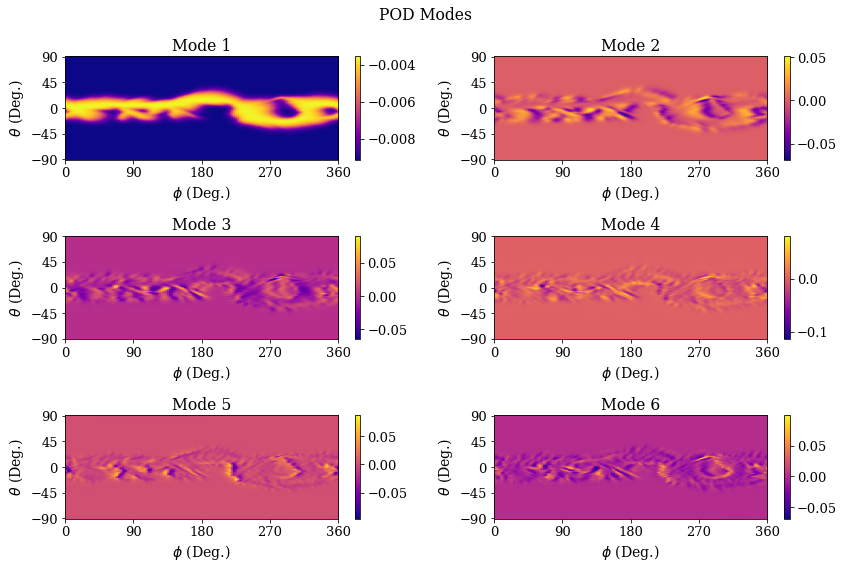

In [34]:
fig = plt.figure(figsize=(12,10))
for id_subplot, snapshot in enumerate(np.arange(0, 6, 1), start=1):
    plt.subplot(4, 2, id_subplot)
    im = plt.imshow(undo_flatten(Vr)[:, :, snapshot].T, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")
    fig.colorbar(im)
    plt.title("Mode " + str(id_subplot))
    plt.xlabel(r"$\phi$ (Deg.)", fontsize=14)
    plt.ylabel(r"$\theta$ (Deg.)", fontsize=14)
    plt.yticks([-90, -45, 0, 45, 90])
    plt.xticks([360, 270, 180, 90, 0])
fig.suptitle("POD Modes")
plt.tight_layout()

fig.savefig("figs/POD_Modes.png", dpi=300, bbox_inches='tight')

In [35]:
roi.pre.projection_error(flatten(X_train), Vr)

0.0004937015024363524

In [36]:
def convert_from_x_to_v(X_ROM):
    # intialize the returned matrix. 
    V_ROM = np.zeros(X_ROM.shape)
    # initial condition
    V_ROM[:,:, 0] = X_ROM[:,:, 0]
    # iterate over all r slices. 
    for jj in range(1, len(r)):
        # compute shift from the linear fit above. 
        shift = shift_function(r[jj].to(u.AU).value, m=m, b=b)
        # define the new shifted coordinate.
        x_new = (p*180/np.pi - shift) % (360)
        # interpolate over the shifted coordinate
        V_ROM[:, :, jj] = interp_fun(p_shifted=x_new, p=p*180/np.pi, t=t, v=X_ROM[:, :, jj]).T
    return V_ROM

# Quadradic-Linear ROM  $\frac{d}{dr}\hat{\mathbf{v}}(r) = \hat c + \hat{A}\hat{\mathbf{v}}(r) + \hat{H}\left(\hat{\mathbf{v}}(r) \otimes\hat{\mathbf{v}}(r) \right) $

In [37]:
start = time.time()
rank=8
Vr, _ = roi.pre.pod_basis(flatten(X_train), r=rank) # Construct the reduced basis.
Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) # Calculate the right-hand side matrix.
model = roi.InferredContinuousROM(modelform="cAH") # Define the model structure.
model.fit(Vr, flatten(X_train), Xdot, P=regularizer(rank, 10**(4), 10**(8))) # Construct the ROM with Operator Inference.
X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF") # Simulate the ROM.
V_ROM = convert_from_x_to_v(undo_flatten(X_ROM))
print("Seconds since epoch =", time.time() - start)

Seconds since epoch = 0.36235904693603516


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62837/4257841147.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


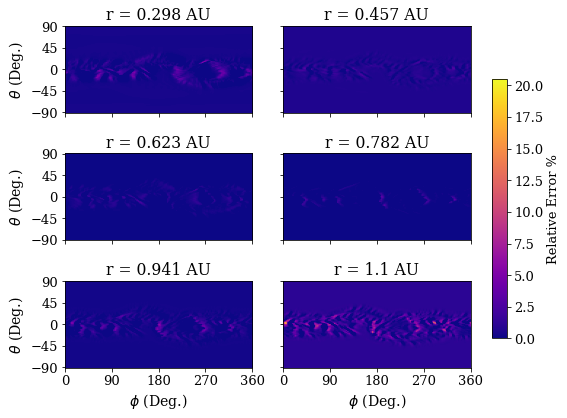

In [38]:
RE = (V_ROM-V)/(V)
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([1*len(r)//6, 3*len(r)//6,  len(r)-1 - len(r)//6], start=0):
    
    im = ax[id_subplot][0].imshow(100*RE[:, :, snapshot].T,  vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][1].imshow(100*RE[:, :, snapshot + len(r)//6].T, vmin=0, vmax=np.max(100*RE), 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot + len(r)//6].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)

#ax[0][0].set_title("MHD \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")
#ax[0][1].set_title("S-OpInf \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("Relative Error %", rotation=90)


plt.tight_layout()

fig.savefig("figs/CR" + str(cr) + "/cAH/RE-comparison-cAH.png", dpi=500, bbox_inches='tight')

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_62837/3469260247.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


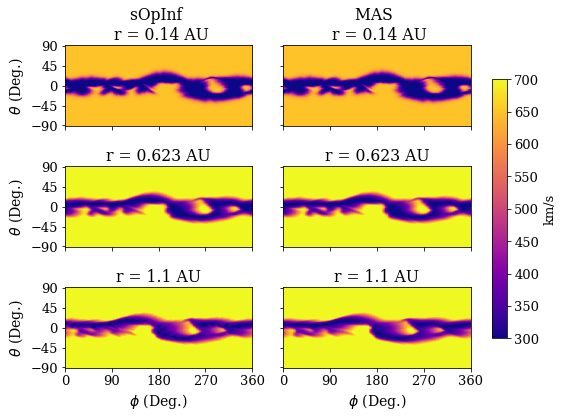

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(7,6))

for id_subplot, snapshot in enumerate([0, len(r)//2, len(r)-1], start=0):
    im = ax[id_subplot][1].imshow(f[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][0].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
    ax[id_subplot][0].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][0].set_xticks([360, 270, 180, 90, 0])
    
    im = ax[id_subplot][0].imshow(V_ROM[:, :, snapshot].T,  vmin=300, vmax=700, 
                    extent=[p[0]*180/np.pi, p[-1]*180/np.pi, t[0]*180/np.pi, t[-1]*180/np.pi],   
                 cmap="plasma", aspect="auto", origin="lower")

    ax[id_subplot][1].set_title("r = " + str(round(r[snapshot].to(u.AU).value, 3)) + " AU")
    ax[id_subplot][1].set_yticks([90, 45, 0, -45, -90])
    ax[id_subplot][1].set_xticks([360, 270, 180, 90, 0])

ax[2][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[2][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[0][1].set_title("MAS \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")
ax[0][0].set_title("sOpInf \n r = " + str(round(r[0].to(u.AU).value, 3)) + " AU")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.99, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

_ = cbar_ax.set_ylabel("km/s", rotation=90)


plt.tight_layout()

fig.savefig("figs/CR" + str(cr) + "/cAH/2D-side-by-side-comparison-cAH.png", dpi=500, bbox_inches='tight')

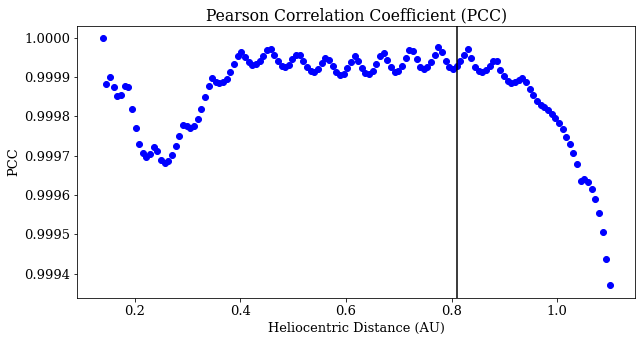

In [85]:
fig, ax = plt.subplots(figsize=(10, 5))
for jj in range(len(r)):
    pcc = stats.pearsonr(np.ndarray.flatten(V[:, :, jj]), np.ndarray.flatten(V_ROM[:, :, jj]))[0]
    ax.scatter(r.to(u.AU).value[jj], pcc, c="b")
_ = ax.axvline(r_train[-1].to(u.AU).value, c="k")
_ = ax.set_xlabel("Heliocentric Distance (AU)")
_ = ax.set_ylabel("PCC")
_ = ax.set_title("Pearson Correlation Coefficient (PCC)")

plt.savefig("figs/CR" + cr + "/cAH/pcc_shifted_operator_inference_mhd.png")

In [86]:
print("PCC Training = ", stats.pearsonr(np.ndarray.flatten(V[:, :, :l]), np.ndarray.flatten(V_ROM[:, :, :l]))[0])
print("PCC Testing = ", stats.pearsonr(np.ndarray.flatten(V[:, :, l:]), np.ndarray.flatten(V_ROM[:, :, l:]))[0])

print("Training RE (mean) %", 100*np.mean(np.abs(V[:, :, :l] - V_ROM[:,:,  :l])/np.abs(V[:, :, :l])))
print("Training RE (median) %", 100*np.median(np.abs(V[:, :, :l] - V_ROM[:, :, :l])/np.abs(V[:, :, :l])))
print("Training RE (max) %", 100*np.max(np.abs(V[:, :, :l] - V_ROM[:, :, :l])/np.abs(V[:,:, :l])))

print("Testing RE (mean) %", 100*np.mean(np.abs(V[:, :, l:] - V_ROM[:, :, l:])/np.abs(V[:,:, l:])))
print("Testing RE (median) %", 100*np.median(np.abs(V[:, :, l:] - V_ROM[:, :, l:])/np.abs(V[:, :, l:])))
print("Testing RE (max) %", 100*np.max(np.abs(V[:, :, l:] - V_ROM[:, :,l:])/np.abs(V[:,:, l:])))

PCC Training =  0.9996994271214409
PCC Testing =  0.9996445525505652
Training RE (mean) % 0.45128894419260324
Training RE (median) % 0.33411843036623595
Training RE (max) % 7.731185314532681
Testing RE (mean) % 0.5399756352704778
Testing RE (median) % 0.35344956543300426
Testing RE (max) % 20.492587879575865


In [87]:
coeff1_array = 10**np.arange(0, 15)
coeff2_array = 10**np.arange(0, 15)

training_error = np.ones((len(coeff1_array),  len(coeff2_array))) * np.inf
testing_error = np.ones((len(coeff1_array),  len(coeff2_array))) * np.inf

for kk, coeff1 in enumerate(coeff1_array):
    for jj, coeff2 in enumerate(coeff2_array):
        Vr, _ = roi.pre.pod_basis(flatten(X_train), r=8) 
        Xdot = roi.pre.xdot_nonuniform(flatten(X_train), r_train.value) 
        model = roi.InferredContinuousROM(modelform="cAH") 
        model.fit(Vr, flatten(X_train), Xdot, P=regularizer(8, coeff1, coeff2)) 
        X_ROM = model.predict(flatten(X[:, :, 0]).reshape(len(p)*len(t)), r.value, method="BDF") 
        X_ROM = undo_flatten(X_ROM)

        if np.shape(flatten(X_ROM)) == np.shape(flatten(V)):
            V_ROM = convert_from_x_to_v(X_ROM)
            # save
            training_error[kk, jj] = np.max(np.abs(V[:, :, :l]-V_ROM[:, :, :l])/V[:, :, :l])
            # save
            testing_error[kk, jj] = np.max(np.abs(V[:, :, l:]-V_ROM[:, :, l:])/V[:, :, l:])

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inferen

normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver
normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)
/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/rom_operator_inference/_core/_base.py:604: IntegrationWarning: Required step size is less than spacing between numbers.
  warnings.warn(self.sol_.message, IntegrationWarning)


normal equations solve failed, switching lstsq solver


/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_40415/3606783956.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pos1 = ax[0].pcolormesh(coeff1_array, coeff2_array, np.log10(training_error[:, :]).T)
/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_40415/3606783956.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pos2 = ax[1].pcolormesh(coeff1_array, coeff2_array, np.log10(testing_error[:, :]).T)


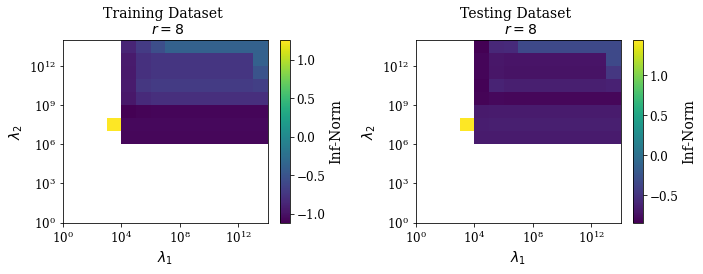

In [88]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

pos1 = ax[0].pcolormesh(coeff1_array, coeff2_array, np.log10(training_error[:, :]).T)

_ = ax[0].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[0].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[0].set_title("Training Dataset \n $r = 8$", fontsize=14)
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)

cbar = fig.colorbar(pos1, ax=ax[0])
cbar.ax.set_ylabel('Inf-Norm', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

pos2 = ax[1].pcolormesh(coeff1_array, coeff2_array, np.log10(testing_error[:, :]).T)


_ = ax[1].set_xlabel(r"$\lambda_{1}$", fontsize=14)
_ = ax[1].set_ylabel(r"$\lambda_{2}$", fontsize=14)
_ = ax[1].set_title("Testing Dataset \n $r = 8$", fontsize=14)
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
cbar = fig.colorbar(pos2, ax=ax[1])
cbar.ax.set_ylabel('Inf-Norm', rotation=90, fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax[1].set_xscale("log")
ax[0].set_xscale("log")
ax[1].set_yscale("log")
ax[0].set_yscale("log")

plt.tight_layout()

In [89]:
idx  = np.unravel_index(training_error.argmin(), training_error.shape)
print("Training lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Training lambda2 =",  np.log10(coeff2_array[idx[1]]))

Training lambda1 = 4.0
Training lambda2 = 8.0


In [90]:
idx  = np.unravel_index(testing_error.argmin(), testing_error.shape)
print("Testing lambda1 =",  np.log10(coeff1_array[idx[0]]))
print("Testing lambda2 =",  np.log10(coeff2_array[idx[1]]))

Testing lambda1 = 4.0
Testing lambda2 = 13.0
